In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Ellipse

from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 12})

np.random.seed(4)

from scipy import stats
from scipy.stats import norm, uniform
import scipy.optimize
from numpy.linalg import inv

In [2]:
# import internal files
import emulators
import utils
import historymatch
import plot

In [3]:
def model_eqn_1(x, theta_0, theta_1, theta_2, theta_3):
    return theta_0 + theta_1*(x) + theta_2*(x**2) + theta_3*(4*x**3)
    
function1 = np.vectorize(model_eqn_1)

In [4]:
def model_eqn_2(x, theta_0, theta_1, theta_2, theta_3):
    #return theta_0 - theta_1*np.sin(x) + theta_2*np.cos(2*x) + theta_3*(x**2)
    #return theta_0 + theta_1*(x) + theta_2*(x**(3/2)) + theta_3*(x**(5/2))
    return theta_0 - theta_1*(x) + theta_2*(x**2) - 2*theta_3*(x**3)
    #return 5*theta_0 - theta_1*(2*x**2) + theta_2*np.cos(2*x) + theta_3*np.exp(x)

function2 = np.vectorize(model_eqn_2)

In [5]:
# define parameter space
x_bound = np.array([-1, 1])
Nx = 100
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)
theta_3_bound = np.array([-1, 1]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound, theta_3_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1)), axis=0)

#theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1)), axis=0)

In [6]:

def toy_model_4D(theta_0, theta_1, theta_2, theta_3):
    
    outputs =  []
    for x in xvals:
        output = theta_0 + theta_1*(x) + theta_2*(x**2) + 4*theta_3*(x**3)
        outputs.append(output)
    for x in xvals:
        output = theta_0 - theta_1*(x) + theta_2*(x**2) - 2*theta_3*(x**3)
        #output = 5*theta_0 - theta_1*(2*x**2) + theta_2*np.cos(2*x) + theta_3*np.exp(x)
        outputs.append(output)
    return np.array(outputs)

In [89]:
# for testing: true datapoints

true_parameters = [-0.1, 0.3, 0.2, -0.4]

ndim = len(true_parameters)

output_range = (toy_model_4D(-1,-1,-1,-1) - toy_model_4D(1,1,1,1))

#sigma_obs = np.abs(output_range)*0.01 # observational uncertainty variance

sigma_obs = np.ones(2*Nx)*1
#var_obs = np.concatenate((np.ones(Nx)*0.1, np.ones(Nx)*0.1)) # observational uncertainty variance

#var_obs = np.abs(output_ratio)*0.1 # observational uncertainty variance

error_obs = np.zeros(2*Nx)
for i in range(2*Nx):
    error_obs[i] = 1 * np.random.normal(0, sigma_obs[i])


z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2], true_parameters[3])# observed datapoint


print(z_1)

z_2 = function2(xvals, true_parameters[0], true_parameters[1], true_parameters[2], true_parameters[3]) + error_obs[Nx:]  # observed datapoint



[ 1.4         1.30303752  1.2100771   1.1210396   1.03584586  0.95441673
  0.87667307  0.80253571  0.73192552  0.66476334  0.60097001  0.54046639
  0.48317333  0.42901168  0.37790228  0.32976598  0.28452364  0.2420961
  0.20240421  0.16536882  0.13091078  0.09895094  0.06941015  0.04220926
  0.01726911 -0.00548944 -0.02614555 -0.04477836 -0.06146703 -0.07629071
 -0.08932855 -0.10065969 -0.1103633  -0.11851852 -0.1252045  -0.13050039
 -0.13448535 -0.13723852 -0.13883906 -0.13936611 -0.13889883 -0.13751637
 -0.13529788 -0.13232251 -0.12866941 -0.12441773 -0.11964662 -0.11443524
 -0.10886273 -0.10300825 -0.09695094 -0.09076996 -0.08454445 -0.07835358
 -0.07227648 -0.06639232 -0.06078023 -0.05551938 -0.05068891 -0.04636798
 -0.04263572 -0.03957131 -0.03725388 -0.03576258 -0.03517658 -0.03557501
 -0.03703704 -0.0396418  -0.04346846 -0.04859615 -0.05510405 -0.06307128
 -0.07257701 -0.08370039 -0.09652056 -0.11111668 -0.12756789 -0.14595336
 -0.16635223 -0.18884365 -0.21350676 -0.24042074 -0.

In [76]:
#obs_data_all = toy_model3D(*true_parameters) + error_f1

Text(0, 0.5, '$z_{2}$')

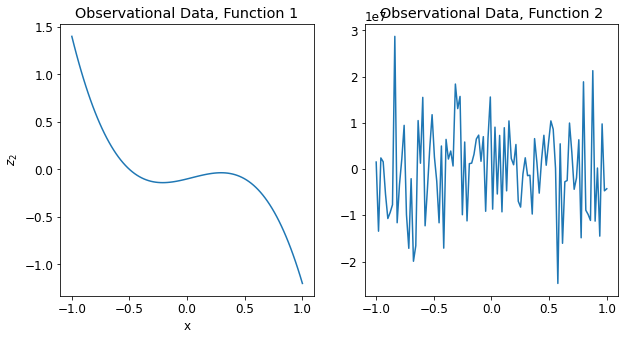

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(xvals, z_1)
ax2.plot(xvals, z_2)

ax1.set_title('Observational Data, Function 1')
ax2.set_title('Observational Data, Function 2')

ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{1}$')
ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{2}$')

In [84]:
def design_matrix_f1(x, p=4):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 1
    X_d[:,1] = x
    X_d[:,2] = x**2
    X_d[:,3] = 4*x**3
    return X_d

def design_matrix_f2(x, p=3):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 1
    X_d[:,1] = -x
    X_d[:,2] = x**2
    X_d[:,3] = -2*x**3
    return X_d



# Create design matrix
X1 = design_matrix_f1(xvals, p=4)
X2 = design_matrix_f2(xvals, p=4)


In [85]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance[i])
    return X_d

In [86]:
A1 = A_matrix(X1, sigma_obs[:Nx])
b1 = z_1 / sigma_obs[:Nx]

A2 = A_matrix(X2, sigma_obs[Nx:])
b2 = z_2 / sigma_obs[Nx:]

In [87]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()


def solve_normal_equation(X_d, y):
    """
    Solve the normal equation.
    
    Args:
        X_d: Design matrix of shape (m,n) with 'm' independent data
               and 'n' features.
        y: Dependent data of shape (m,1).
                  
    Returns:
        theta_best: Best parameters, array of shape (n,).
    """
    theta_best = ((np.linalg.inv(X_d.T.dot(X_d))).dot(X_d.T)).dot(y)
    return theta_best.flatten()

In [90]:
#thet = solve_theta(X1,z_1)

thet = solve_normal_equation(X1, z_1)

print(z_1)
# [-0.1, 0.3, 0.2, -0.4]

[ 1.4         1.30303752  1.2100771   1.1210396   1.03584586  0.95441673
  0.87667307  0.80253571  0.73192552  0.66476334  0.60097001  0.54046639
  0.48317333  0.42901168  0.37790228  0.32976598  0.28452364  0.2420961
  0.20240421  0.16536882  0.13091078  0.09895094  0.06941015  0.04220926
  0.01726911 -0.00548944 -0.02614555 -0.04477836 -0.06146703 -0.07629071
 -0.08932855 -0.10065969 -0.1103633  -0.11851852 -0.1252045  -0.13050039
 -0.13448535 -0.13723852 -0.13883906 -0.13936611 -0.13889883 -0.13751637
 -0.13529788 -0.13232251 -0.12866941 -0.12441773 -0.11964662 -0.11443524
 -0.10886273 -0.10300825 -0.09695094 -0.09076996 -0.08454445 -0.07835358
 -0.07227648 -0.06639232 -0.06078023 -0.05551938 -0.05068891 -0.04636798
 -0.04263572 -0.03957131 -0.03725388 -0.03576258 -0.03517658 -0.03557501
 -0.03703704 -0.0396418  -0.04346846 -0.04859615 -0.05510405 -0.06307128
 -0.07257701 -0.08370039 -0.09652056 -0.11111668 -0.12756789 -0.14595336
 -0.16635223 -0.18884365 -0.21350676 -0.24042074 -0.

In [83]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

In [ ]:
def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [ ]:
#cov_matrix_f1 = covariance(X1, var_obs[:Nx])
#cov_matrix_f2 = covariance(X2, var_exp_f2)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)


In [ ]:
# calculate product of posteriors
H3 = inv(inv(H1) + inv(H2))

H32 =  H1.dot( inv(H1 + H2).dot(H2) )

L1 = inv(np.linalg.cholesky(H1 + H2)).dot(H1)
L2 = inv(np.linalg.cholesky(H1 + H2)).dot(H2)

H33 = np.dot(L1.T, L2)

TM_mean = np.dot(np.dot(H3,inv(H1)),theta_f1) + np.dot(np.dot(H3,inv(H2)),theta_f2)

print(H3.dot((np.dot(inv(H1),theta_f1) + np.dot(inv(H2),theta_f2))))

print(TM_mean)

In [ ]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [ ]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$', r'$\theta_{4}$']
    N = len(theta_best)
    
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                if color == 'mediumaquamarine':
                    ax_right = ax.twinx()
                    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                #ax.set_ylim([-5, 5])
                
            else:
                ax.axis('off')

In [ ]:
color_list = ['plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

ax = fig.axes[5]
plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
plot_ellipses(fig, parameter_bounds, true_parameters, H3, TM_mean, theta_vals, color_list[2])


ax.scatter(1,1,color=color_list[0],label='Function 1')
ax.scatter(1,1,color=color_list[1],label='Function 2')
ax.legend(loc='center')



In [ ]:
file2 = open("4D_analytic_mean.txt", "w")

np.savetxt(file2, TM_mean)
    
file2.close()

file1 = open("4D_analytic_cov.txt", "w")

for i in range(H3.shape[0]):
    np.savetxt(file1, H3[i])
    
file1.close()


true_parameters = [-0.1, 0.3, 0.2, -0.4]
print(TM_mean)


In [ ]:
# calculate product of posteriors

C1 = np.array([[0.7,0.9],[0.9, 1.9]])
C2 = np.array([[0.5,0],[0, 1.2]])

C3 = inv(inv(C1) + inv(C2))

mean = np.dot(np.dot(C3,inv(C1)),[4,6]) + np.dot(np.dot(C3,inv(C2)),[3,8])
print(mean)